# Data understanding

In [1]:
#Used for displaying plots below the cell
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [2]:
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0)

In [3]:
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,"2,55",17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,"2,75",17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


The dataset seems to contain data about the shopping habits of the customers of a grocery store chain.  
Each row represents an object purchased:  
- BasketID: represents a batch of items bought at the same time, there can be more entries with the same BasketID  
- BasketDate: self explanatory, if the BasketID is the same between entries then also the BasketDate should stay the same  
- Sale: represents the value of the item, we need to figure out if it refers to a single item or the item*quantity
- CustomerID: identifies a unique customer
- ProdID: identifies a unique product for sale
- ProdDescr: describes the product
- Qta: number of items of the with id ProdID bought

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         471910 non-null  object 
 1   BasketDate       471910 non-null  object 
 2   Sale             471910 non-null  object 
 3   CustomerID       406830 non-null  float64
 4   CustomerCountry  471910 non-null  object 
 5   ProdID           471910 non-null  object 
 6   ProdDescr        471157 non-null  object 
 7   Qta              471910 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.4+ MB


In [5]:
len(df.index)

471910

Only ProdDescr and CustomerID contain null values.

In [6]:
df.describe()

,CustomerID,Qta
count,406830.000000,471910.000000
mean,15287.684160,10.716533
std,1713.603074,231.355136
min,12346.000000,-80995.000000
25%,13953.000000,1.000000
50%,15152.000000,4.000000
75%,16791.000000,12.000000
max,18287.000000,80995.000000


The statistics regarding the CustomerID are meaningless since the assignment of an ID is usually done progressively and without having any additional information on the customer.  
We need to fix the data type situation in order to get a better understanding of the data set.

## Data type conversion  
Let's start by checking out the data type that pandas assigns to the attributes, in order to get an idea of the potential problems.

In [7]:
df.dtypes

BasketID            object
BasketDate          object
Sale                object
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

In [8]:
df = df.convert_dtypes()

In [9]:
df.dtypes

BasketID           string
BasketDate         string
Sale               string
CustomerID          Int64
CustomerCountry    string
ProdID             string
ProdDescr          string
Qta                 Int64
dtype: object

CustomerID got converted to a reasonable data type while the others became a generic "string".  
We don't however care for CustomerID as a number.

In [10]:
df["CustomerID"] = df["CustomerID"].astype("string")

## BasketID

Let's check why BasketID is not an int64 like CustomerID.

In [11]:
nonNumSeries = pd.to_numeric(df.BasketID, errors='coerce').isnull()
# Count and print the records with BasketIDs containing a non-numeric value
print(df[nonNumSeries])
print(len(df[nonNumSeries]))

       BasketID      BasketDate    Sale CustomerID CustomerCountry  ProdID  \
141     C536379  01/12/10 09:41    27,5      14527  United Kingdom       D   
154     C536383  01/12/10 09:49    4,65      15311  United Kingdom  35004C   
235     C536391  01/12/10 10:24    1,65      17548  United Kingdom   22556   
236     C536391  01/12/10 10:24    0,29      17548  United Kingdom   21984   
237     C536391  01/12/10 10:24    0,29      17548  United Kingdom   21983   
...         ...             ...     ...        ...             ...     ...   
540449  C581490  09/12/11 09:57    0,83      14397  United Kingdom   23144   
541541  C581499  09/12/11 10:28  224,69      15498  United Kingdom       M   
541715  C581568  09/12/11 11:57   10,95      15311  United Kingdom   21258   
541716  C581569  09/12/11 11:58    1,25      17315  United Kingdom   84978   
541717  C581569  09/12/11 11:58    1,25      17315  United Kingdom   20979   

                               ProdDescr  Qta  
141            

In [12]:
df.loc[nonNumSeries, "BasketID"].str.slice(0,1).unique()

<StringArray>
['C', 'A']
Length: 2, dtype: string

It seems that a good chunk of the BasketID values start with a "C" and some with "A" instead of being just numbers.  

In [13]:
basket_c_df = df.loc[df["BasketID"].str.get(0) == "C"]
len_basket_c = len(basket_c_df)
print(f"Records starting with 'C' (Size: {len_basket_c}):\n")
basket_c_df.head(5)

Records starting with 'C' (Size: 9084):



,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,01/12/10 09:41,"27,5",14527,United Kingdom,D,Discount,-1
154,C536383,01/12/10 09:49,"4,65",15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,01/12/10 10:24,"1,65",17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,01/12/10 10:24,"0,29",17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,01/12/10 10:24,"0,29",17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


In [14]:
basket_a_df = df.loc[df["BasketID"].str.get(0) == "A"]
len_basket_a = len(basket_a_df)
print(f"Records starting with 'A' (Size: {len_basket_a}):\n")
basket_a_df.head(10)

Records starting with 'A' (Size: 2):



,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,12/08/11 14:51,"-11062,06",<NA>,United Kingdom,B,Adjust bad debt,1
299984,A563187,12/08/11 14:52,"-11062,06",<NA>,United Kingdom,B,Adjust bad debt,1


There seems to be a strong correlation between the "C" and a negative quantity, this could indicate a customer that asked for a refund.  

There is also some interesting correlation between the "A" start and a ProdDescr containing "Adjust bad debt", maybe the "A" stands for adjust and since the CustomerID in both cases is NaN this could be an operation that concerns only the management of the shop and not something that concerns the customers (which is our primary objective).  
These records, however, are too few to be meaningful, they skew too much the characteristics of the sale data (outliers) and they don't concern the activities of the customers.

Let's try to add a "BasketID type A" and "BasketID type C" binary attribute (0/1) and see if there are correlations.

In [15]:
df_tmp = df.copy()

#Initialise all the cells to 0
df_tmp["BasketIDTypeA"] = 0
df_tmp["BasketIDTypeC"] = 0

#Set the cells appropriately depending on the BasketID type
df_tmp.loc[(df_tmp["BasketID"].str.get(0) == "A"), "BasketIDTypeA"] = 1
df_tmp.loc[(df_tmp["BasketID"].str.get(0) == "C"), "BasketIDTypeC"] = 1

#No clue why it doesn't respond with a Warning...
#Remove the initial letter from BasketID where necessary
df_tmp.loc[(df_tmp["BasketID"].str.get(0) == "A"), "BasketID"] = df_tmp.loc[(df_tmp["BasketID"].str.get(0) == "A"), "BasketID"].str.slice(1, -1)
df_tmp.loc[(df_tmp["BasketID"].str.get(0) == "C"), "BasketID"] = df_tmp.loc[(df_tmp["BasketID"].str.get(0) == "C"), "BasketID"].str.slice(1, -1)

df_tmp["QtaPositive"] = 0
df_tmp.loc[df_tmp["Qta"] > 0, "QtaPositive"] = 1

df_tmp.corr()

,Qta,BasketIDTypeA,BasketIDTypeC,QtaPositive
Qta,1.000000,-0.000086,-0.024892,0.029379
BasketIDTypeA,-0.000086,1.000000,-0.000288,0.000299
BasketIDTypeC,-0.024892,-0.000288,1.000000,-0.964446
QtaPositive,0.029379,0.000299,-0.964446,1.000000


The BasketID of type C is strongly negative correlated with the sign of Qta.

Let's investigate the "C" hypothesis.

Judging by the ProdDescr it seems that the entries with BasketID starting with C is not concerned with refunds, at least not entirely.  
We will get back to this point later.

## BasketDate
Let's convert the BasketDate type from String to datetime, just in case we need to perform some analysis that requires ordinal data.

In [16]:
df.BasketDate = pd.to_datetime(df.BasketDate)

In [17]:
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,"2,55",17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,"3,39",17850,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,"2,75",17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,"3,39",17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,"3,39",17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  string        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  string        
 3   CustomerID       406830 non-null  string        
 4   CustomerCountry  471910 non-null  string        
 5   ProdID           471910 non-null  string        
 6   ProdDescr        471157 non-null  string        
 7   Qta              471910 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), string(6)
memory usage: 32.9 MB


## Sale

The "Sale" attribute is considered a generic object while it should be recognised as a float.  
Let's see why.

In [19]:
df.Sale.map(type)

0         <class 'str'>
1         <class 'str'>
2         <class 'str'>
3         <class 'str'>
4         <class 'str'>
              ...      
541905    <class 'str'>
541906    <class 'str'>
541907    <class 'str'>
541908    <class 'str'>
541909    <class 'str'>
Name: Sale, Length: 471910, dtype: object

In [20]:
df.Sale

0         2,55
1         3,39
2         2,75
3         3,39
4         3,39
          ... 
541905     2,1
541906    4,15
541907    4,15
541908    4,95
541909      18
Name: Sale, Length: 471910, dtype: string

It seems that Sale uses a comma instead of a point to separate the decimal part, so it is considered a "str" instead of a "float64".  
Let's replace the commas in "Sale" with dots in order to have them be recognised as float64 by pandas.

In [21]:
df.Sale = df.Sale.apply(lambda x: x.replace(',','.'))

In [22]:
df.Sale = df.Sale.astype("float64")

In [23]:
df.dtypes

BasketID                   string
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 string
CustomerCountry            string
ProdID                     string
ProdDescr                  string
Qta                         Int64
dtype: object

## CustomerID

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  string        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  string        
 4   CustomerCountry  471910 non-null  string        
 5   ProdID           471910 non-null  string        
 6   ProdDescr        471157 non-null  string        
 7   Qta              471910 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), string(5)
memory usage: 32.9 MB


Let's see why the number of non-null CustomerID entries is so low and if there are any interesting properties to be found.

In [25]:
null_customer = df.loc[df.CustomerID.isnull()]
null_customer

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
1444,536544,2010-01-12 14:32:00,2.51,<NA>,United Kingdom,21774,DECORATIVE CATS BATHROOM BOTTLE,2
1446,536544,2010-01-12 14:32:00,1.66,<NA>,United Kingdom,21787,RAIN PONCHO RETROSPOT,2
1447,536544,2010-01-12 14:32:00,1.66,<NA>,United Kingdom,21790,VINTAGE SNAP CARDS,9
1448,536544,2010-01-12 14:32:00,2.51,<NA>,United Kingdom,21791,VINTAGE HEADS AND TAILS CARD GAME,2
1450,536544,2010-01-12 14:32:00,0.43,<NA>,United Kingdom,21802,CHRISTMAS TREE HEART DECORATION,9
...,...,...,...,...,...,...,...,...
541532,581498,2011-09-12 10:26:00,4.13,<NA>,United Kingdom,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,1
541534,581498,2011-09-12 10:26:00,3.29,<NA>,United Kingdom,85049a,TRADITIONAL CHRISTMAS RIBBONS,5
541538,581498,2011-09-12 10:26:00,4.96,<NA>,United Kingdom,85150,LADIES & GENTLEMEN METAL SIGN,1
541539,581498,2011-09-12 10:26:00,10.79,<NA>,United Kingdom,85174,S/4 CACTI CANDLES,1


In [26]:
#for v in null_customer.BasketID.unique():
#    test = df.loc[df["BasketID"] == v].loc[lambda i: i["CustomerID"].notna()]
#    if(not test.empty):
#        print(test)
#This provided no output so we can assume that there are no entries containing a 
#non-NaN with same BasketID as the ones that have CustomerID NaN

The mystery will stay unsolved for now

## Correlation and distributions

In [27]:
df.describe()

,Sale,Qta
count,471910.000000,471910.000000
mean,4.030945,10.716533
std,83.769380,231.355136
min,-11062.060000,-80995.000000
25%,1.250000,1.000000
50%,2.080000,4.000000
75%,3.750000,12.000000
max,38970.000000,80995.000000


In [28]:
df.corr()

,Sale,Qta
Sale,1.000000,-0.001247
Qta,-0.001247,1.000000


No meaningful correlation between the numerical attributes

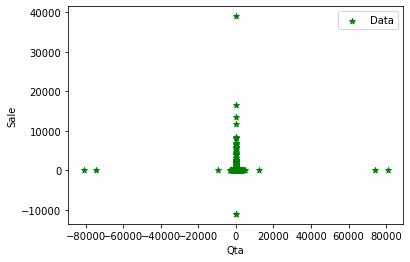

In [29]:
plt.scatter(df['Qta'], 
            df['Sale'], color='g', marker='*', label='Data')
plt.xlabel('Qta')
plt.ylabel('Sale')
plt.legend()
plt.show()

# Data preparation

## Additional features

Let's add some new features into the data frame

In [30]:
#Possibly a cleaner approach, to consider
#funcs = {'I' : lambda df: df.Sale.loc[df.]), 
#         'Iu' : lambda df: df['foo']+1,
#         'Imax' : ,
#         'E' : }
#for k in funcs.keys():
#    if k not in aux_df:
#        aux_df[k] = funcs[k](df)

unq_cust_id = df["CustomerID"].sort_values().unique()[0:-1] #Remove NaN value
aux_df = pd.DataFrame(data=unq_cust_id, columns=["CustomerID"])

tot_items_list = []
unq_item_list = []
max_item_list = []

for v in unq_cust_id:
    cust_data = df.loc[df["CustomerID"] == v]
    
    #I
    tot_items_list.append(cust_data.Qta.sum(axis=0))
    
    #Iu
    unq_item_list.append(len(cust_data.ProdID.unique()))
    
    #Imax
    cust_sessions = cust_data["BasketID"].unique()
    max_item_bought = 0 #This could be problematic
    for v1 in cust_sessions:
        cur_session = cust_data.loc[cust_data["BasketID"] == v1]
        cur_amount = cur_session.Qta.sum(axis=0)
        
        if(cur_amount > max_item_bought):
            max_item_bought = cur_amount
    max_item_list.append(max_item_bought)

I = pd.Series(data=tot_items_list)
Iu = pd.Series(data=unq_item_list)
Imax = pd.Series(data=max_item_list)
    
aux_df["I"] = I
aux_df["Iu"] = Iu
aux_df["Imax"] = Imax

aux_df

KeyboardInterrupt: 